In [1]:
from deep_traffic_generation.linear_vae import LinearVAE
from deep_traffic_generation.core.datasets import TrafficDataset
from deep_traffic_generation.core.utils import traffic_from_data

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/denoised_v3.pkl",
    features=["latitude", "longitude", "altitude", "timedelta"],
    init_features=[],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    mode="linear",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 17914
    File location: ../deep_traffic_generation/data/denoised_v3.pkl
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = LinearVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/linear_vae/version_2/checkpoints/epoch=199-step=2399.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/linear_vae/version_2/hparams.yaml",
    input_dim = dataset.input_dim,
    seq_len = dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

LinearVAE(
  (encoder): _Encoder(
    (encoder): FCN(
      (encoder): Sequential(
        (0): Linear(in_features=800, out_features=400, bias=True)
      )
    )
    (z_loc): Linear(in_features=400, out_features=20, bias=True)
    (z_log_var): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): FCN(
    (encoder): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): Linear(in_features=400, out_features=800, bias=True)
    )
  )
)

In [7]:
n_to_show = 20
data = model.decoder(torch.normal(0, 1, size=(n_to_show, model.hparams.encoding_dim)))
print(data.size())
data = data.detach().numpy()

data = data.reshape((data.shape[0], -1))
data = model.scaler.inverse_transform(data)

# add latitude longitude info
# info = np.ones((n_to_show, 2)) * 40
# data = np.concatenate((info, data), axis=1)

builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

torch.Size([20, 800])


,count
flight_id,
0,200
1,200
8,200
7,200
6,200
5,200
4,200
3,200
2,200


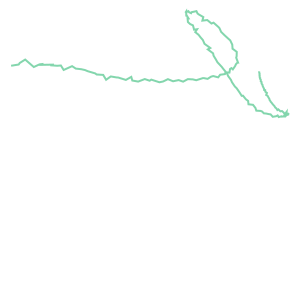

In [16]:
traffic[2]